## Seasonality and Events

In this section, users will learn

1. modeling complex seasonality
2. modeling events

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM
from karpiu.utils import insert_events, extend_ts_features

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

Recall in quickstart, a demo on non-seasonal data is shown. This time the demo will use a exhibit yearly and weekly seasonal pattern with events.

In [3]:
RAW_DATA_FILE = "resource/seasonal/df.csv"
SCALABILITY_FILE = "resource/seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
scalability_df = pd.read_csv(SCALABILITY_FILE)
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")

Note that the one-hot-encoded dummies are already appended in the dataframe.

In [5]:
event_cols = [
    "new-years-day",
    "martin-luther-king-jr-day",
    "washingtons-birthday",
    "memorial-day",
    "independence-day",
    "labor-day",
    "columbus-day",
    "veterans-day",
    "veterans-day-observed",
    "thanksgiving",
    "christmas-day",
    "independence-day-observed",
    "juneteenth-national-independence-day-observed",
    "juneteenth-national-independence-day",
    "christmas-day-observed",
    "new-years-day-observed",
]

In [6]:
df.head(5)

,date,sales,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,...,columbus-day,veterans-day,veterans-day-observed,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
0,2019-01-01,1125.00000,2223.00000,7925.00000,0.00000,0.00000,0.00000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-02,784.00000,2954.00000,7175.00000,3962.00000,4036.00000,0.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-03,872.00000,1343.00000,4171.00000,2529.00000,0.00000,5566.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-04,1098.00000,2345.00000,0.00000,3267.00000,4199.00000,6033.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-05,3751.00000,1582.00000,4792.00000,0.00000,2311.00000,6302.00000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fitting a MMM

Since the model is using Fourier terms in fitting seasonality, fs_orders is also required. Note that karpiu also supports complex seasonality which takes list of `seasonality` and `fs_orders`.

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=event_cols,
    seed=2022,
    adstock_df=adstock_df,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
    events_sigma_prior=0.3,
)

2023-02-27 23:01:30 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.00245,
}
mmm.set_hyper_params(best_params)

2023-02-27 23:01:30 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-27 23:01:30 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-27 23:01:30 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245


Fit the model with supplied dataframe.

Feel free to use more chains if the machine running the model has multiple cores.

In [9]:
mmm.fit(df, num_sample=100, num_warmup=400, chains=1)

2023-02-27 23:01:30 - karpiu-mmm - INFO - Fit final model.
2023-02-27 23:01:30 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-27 23:01:30 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-27 23:01:30 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-27 23:01:30 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 400 and samples(per chain): 100.


chain 1 |          | 00:00 Status

2023-02-27 23:02:32 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.5334005500000001) is within common range (0, 0.8].


### Model Regression Coefficents

Now, we can see all the Fourier and event terms regression coefficient.

In [10]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05125,0.03454,0.07178,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.06685,0.05136,0.08586,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.19977,0.17910,0.22420,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.12588,0.10993,0.14852,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.08965,0.07557,0.11248,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.54941,0.54576,0.55258,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.38330,0.38050,0.38651,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.66090,-0.66599,-0.65773,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,-0.34243,-0.34616,-0.33761,0.00000,1.00000,0.00000,0.30000
9,s365.25_fs_cos1,Regular,0.15520,0.14613,0.16246,1.00000,0.00000,0.00000,0.30000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version. Here a demo of using `insert_event` and `extend_ts_features` are also shown to generate future dataframe for long-term forecast checking.

In [11]:
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [12]:
future_df = extend_ts_features(df, 365, date_col="date")
future_df, event_cols = insert_events(future_df, date_col="date", country="US")

In [13]:
pred_df = mmm.predict(future_df)

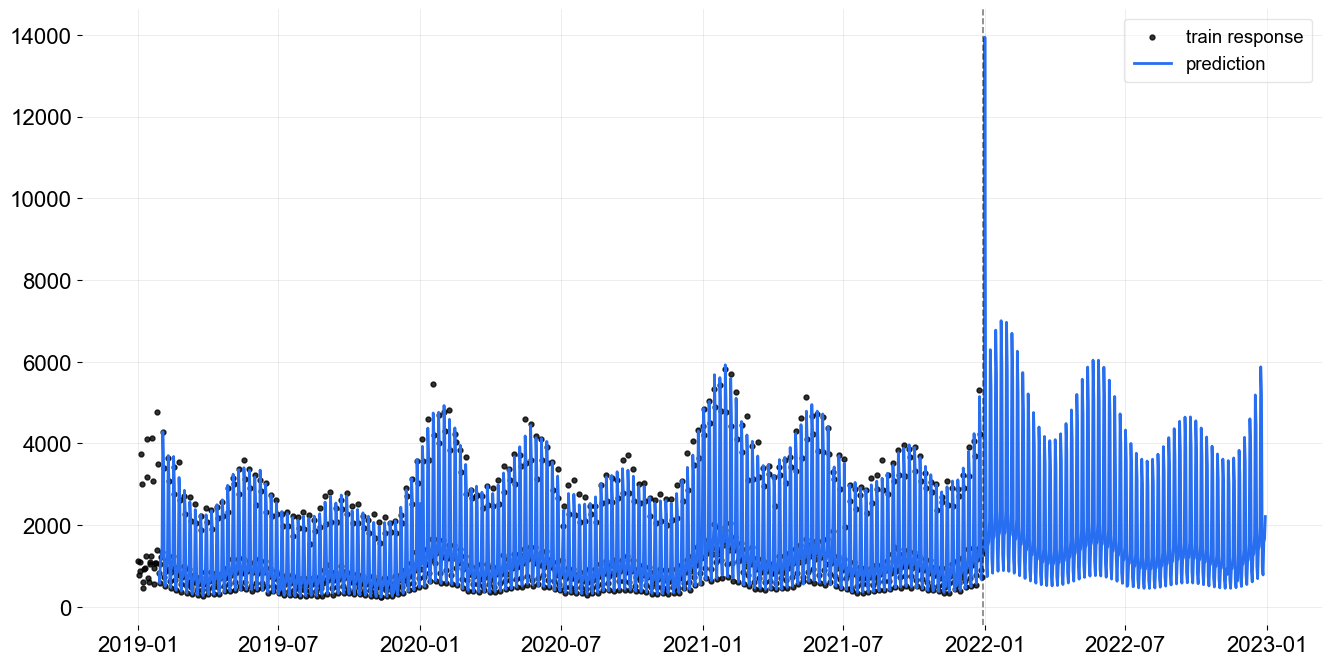

In [14]:
plot_predicted_data(
    training_actual_df=df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
);

In [15]:
pred_df = mmm.predict(future_df, decompose=True)

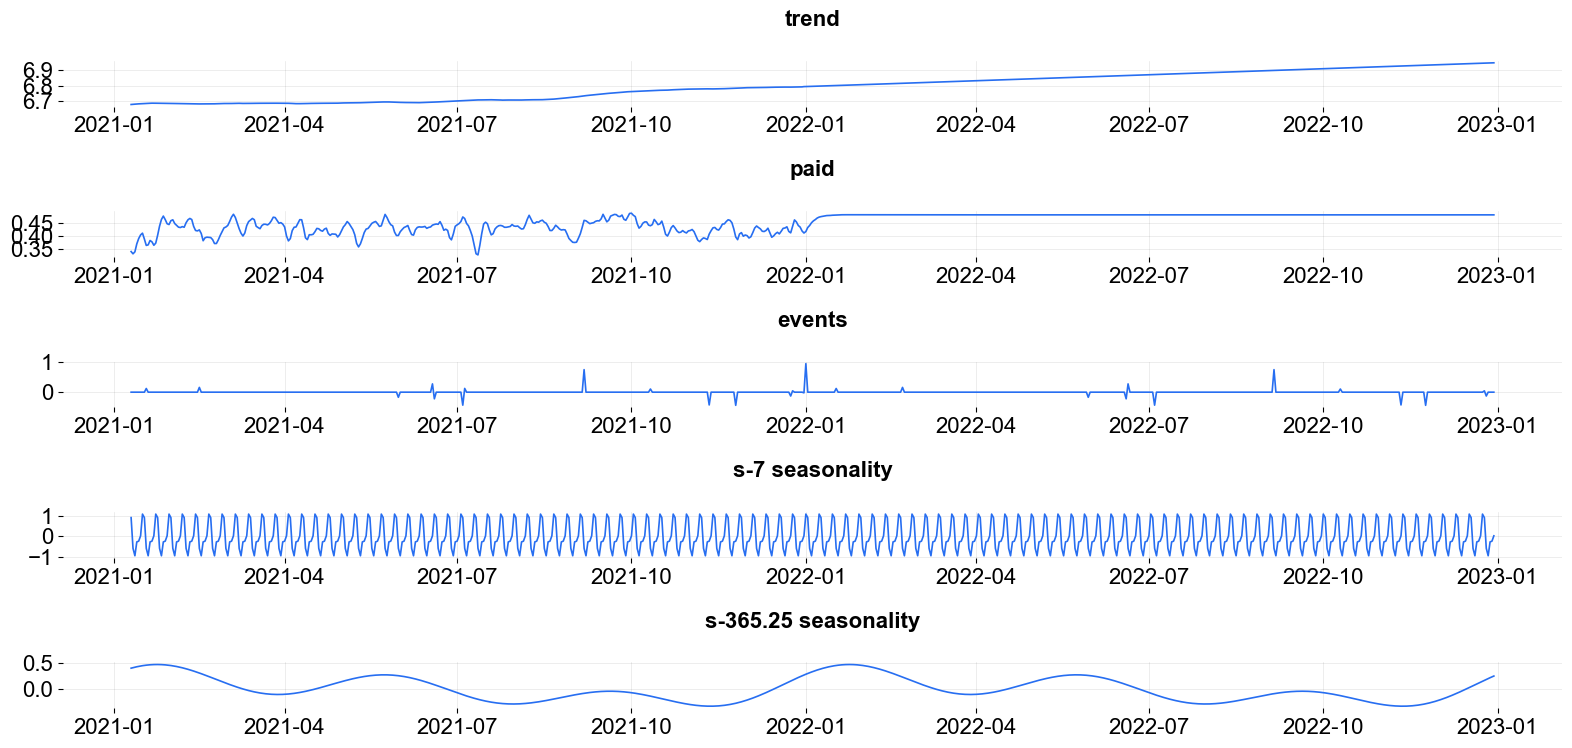

In [16]:
plot_predicted_components(
    predicted_df=pred_df[-720:],
    date_col="date",
    plot_components=[
        "trend",
        "paid",
        "events",
        "s-7 seasonality",
        "s-365.25 seasonality",
    ],
);